In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import matplotlib.pyplot as plt
tf.compat.v1.set_random_seed(0)
from tensorflow import keras
import numpy as np
np.random.seed(0)
import itertools
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
train_gen = image_dataset_from_directory(directory="../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train",
                                         image_size=(256, 256))
test_gen = image_dataset_from_directory(directory="../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid",
                                        image_size=(256, 256))

rescale = Rescaling(scale=1.0/255)
train_gen = train_gen.map(lambda image,label:(rescale(image),label))
test_gen  = test_gen.map(lambda image,label:(rescale(image),label))

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


In [3]:
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Load the VGG16 model (excluding the top layer)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Create a Sequential model
model = keras.Sequential()

# Add the pre-trained VGG16 model
model.add(base_model)

# Flatten layer
model.add(Flatten())

# Dense layers
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(38, activation='softmax'))

# Compile the model
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

# Define a ModelCheckpoint callback to save the model
checkpoint_filepath = 'model_checkpoint_vgg16.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',  # You can choose the metric to monitor, e.g., validation accuracy
    mode='max',
    save_best_only=True
)

# Train the model with the ModelCheckpoint callback
history = model.fit(train_gen, epochs=10, validation_data=test_gen, callbacks=[model_checkpoint_callback])


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
2197/2197 [==============================] - 275s 121ms/step - loss: 0.8263 - accuracy: 0.7515 - val_loss: 28.0974 - val_accuracy: 0.9083
Epoch 2/10
2197/2197 [==============================] - 265s 121ms/step - loss: 0.2975 - accuracy: 0.9143 - val_loss: 22.9436 - val_accuracy: 0.9421
Epoch 4/10
2197/2197 [==============================] - 265s 120ms/step - loss: 0.2656 - accuracy: 0.9315 - val_loss: 64.9820 - val_accuracy: 0.9477
Epoch 5/10
2197/2197 [==============================] - 265s 120ms/step - loss: 0.2150 - accuracy: 0.9419 - val_loss: 59.6755 - val_accuracy: 0.9487
Epoch 6/10
2197/2197 [==============================] - 266s 121ms/step - loss: 0.1729 - accuracy: 0.9502 - val_loss: 47.5260 - val_accuracy: 0.9522
Epoch 7/10
2197/2197 [==============================] - 261s 119ms/step - loss: 0.1398 - accuracy: 0.9595 - val_loss: 46.0376 - val_accuracy: 0.9545
Epoch 9/10
2197/2197 [===================

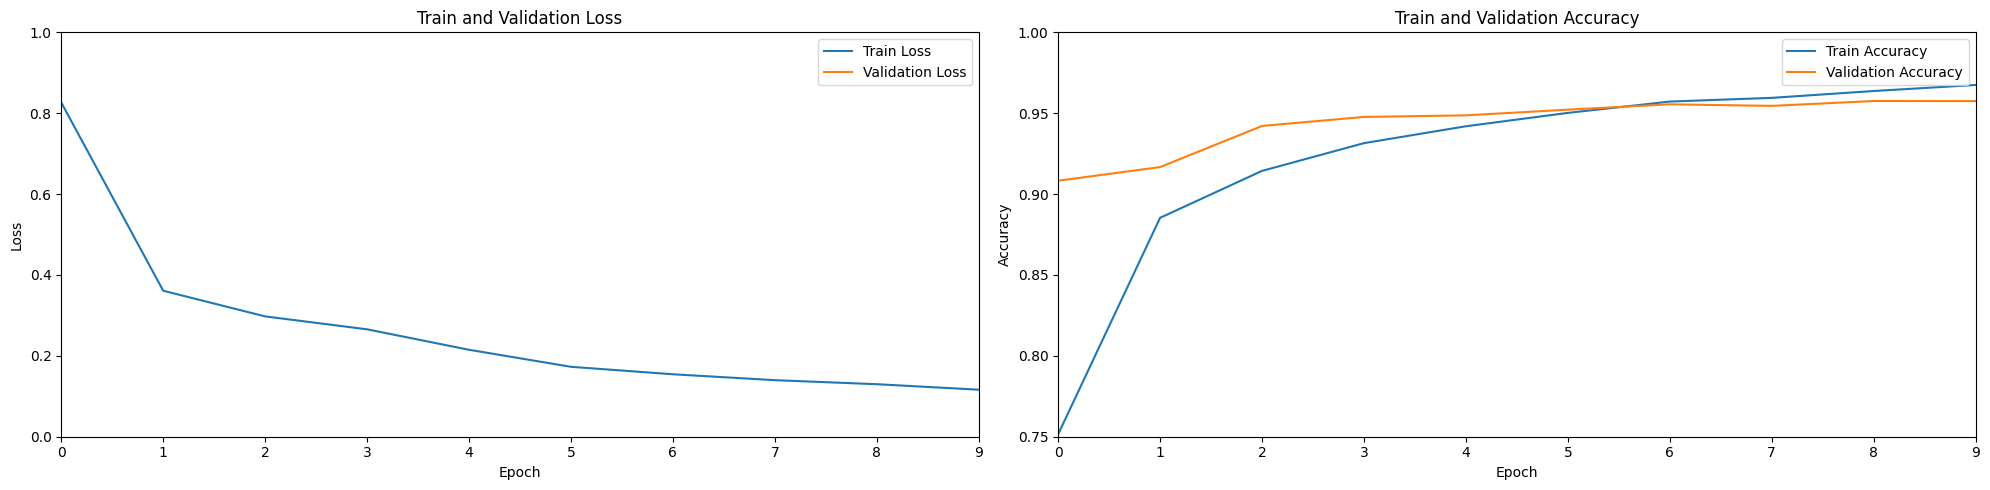

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 9)  # Adjusted xlim to match the number of epochs
plt.ylim(0.0, 1.0)
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9)  # Adjusted xlim to match the number of epochs
plt.ylim(0.75, 1.0)
plt.legend()

plt.tight_layout()
plt.show()


In [5]:
labels = []
predictions = []
for x,y in test_gen:
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(model.predict(x),1).numpy())

1/1 [==============================] - 0s 168ms/step


In [6]:
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

In [7]:
print("Train Accuracy  : {:.2f} %".format(history.history['accuracy'][-1]*100))
print("Test Accuracy   : {:.2f} %".format(accuracy_score(labels, predictions) * 100))
print("Precision Score : {:.2f} %".format(precision_score(labels, predictions, average='micro') * 100))
print("Recall Score    : {:.2f} %".format(recall_score(labels, predictions, average='micro') * 100))

Train Accuracy  : 96.75 %
Test Accuracy   : 95.75 %
Precision Score : 95.75 %
Recall Score    : 95.75 %


<Figure size 2000x500 with 0 Axes>

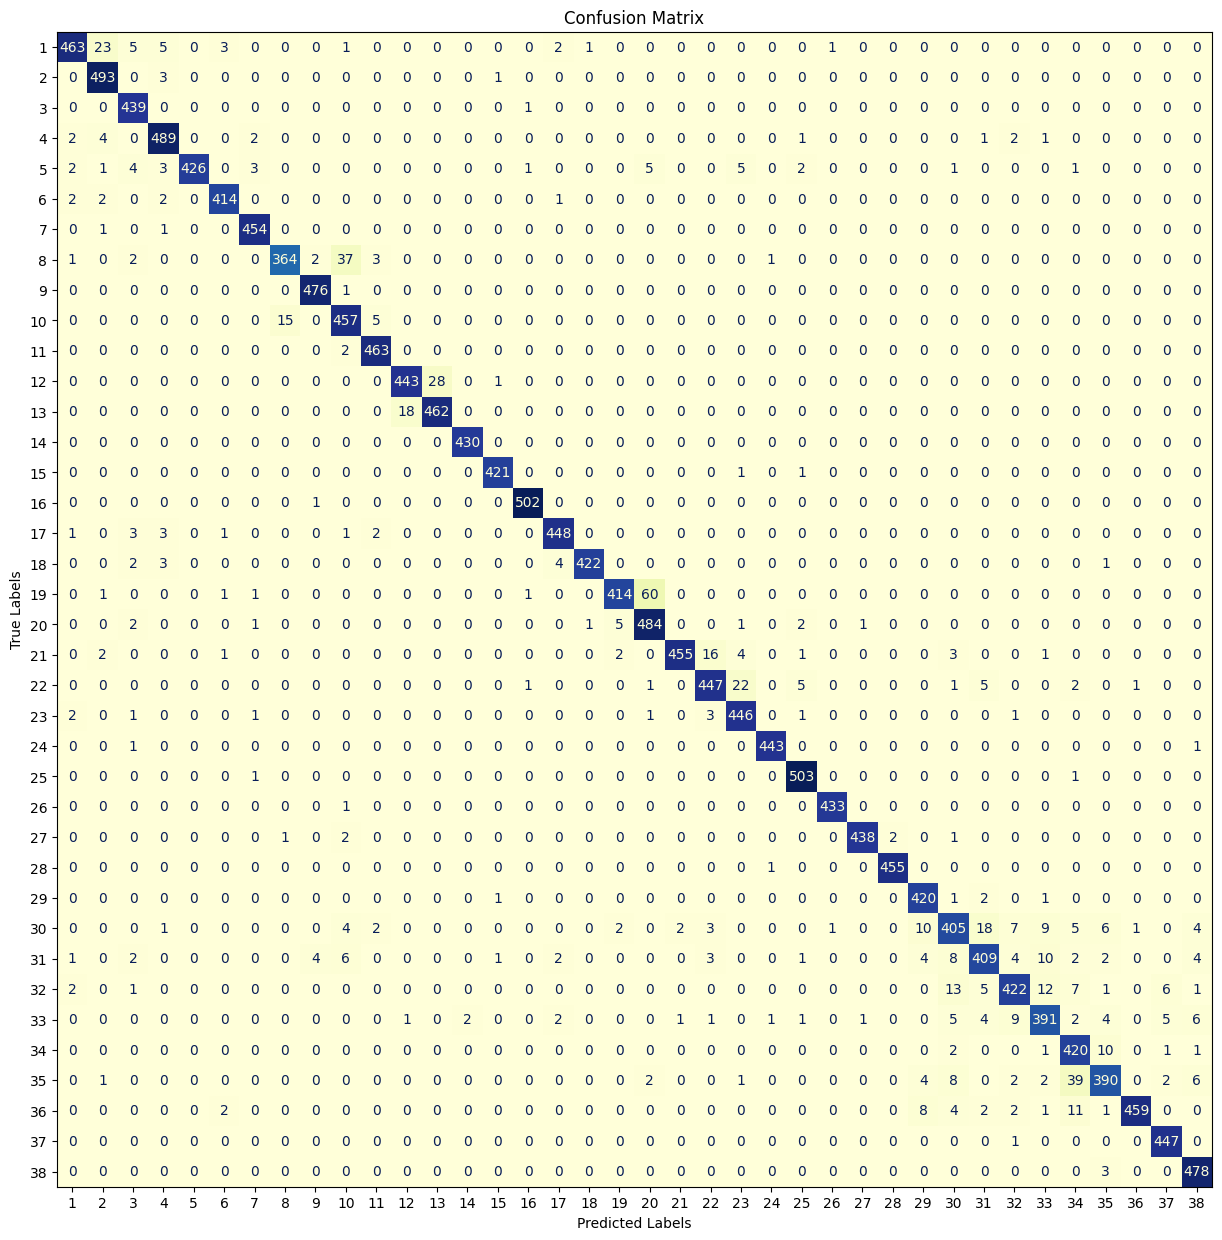

In [8]:
plt.figure(figsize= (20,5))
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(range(1,39)))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,colorbar= False,cmap = 'YlGnBu')
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

<Figure size 2000x500 with 0 Axes>

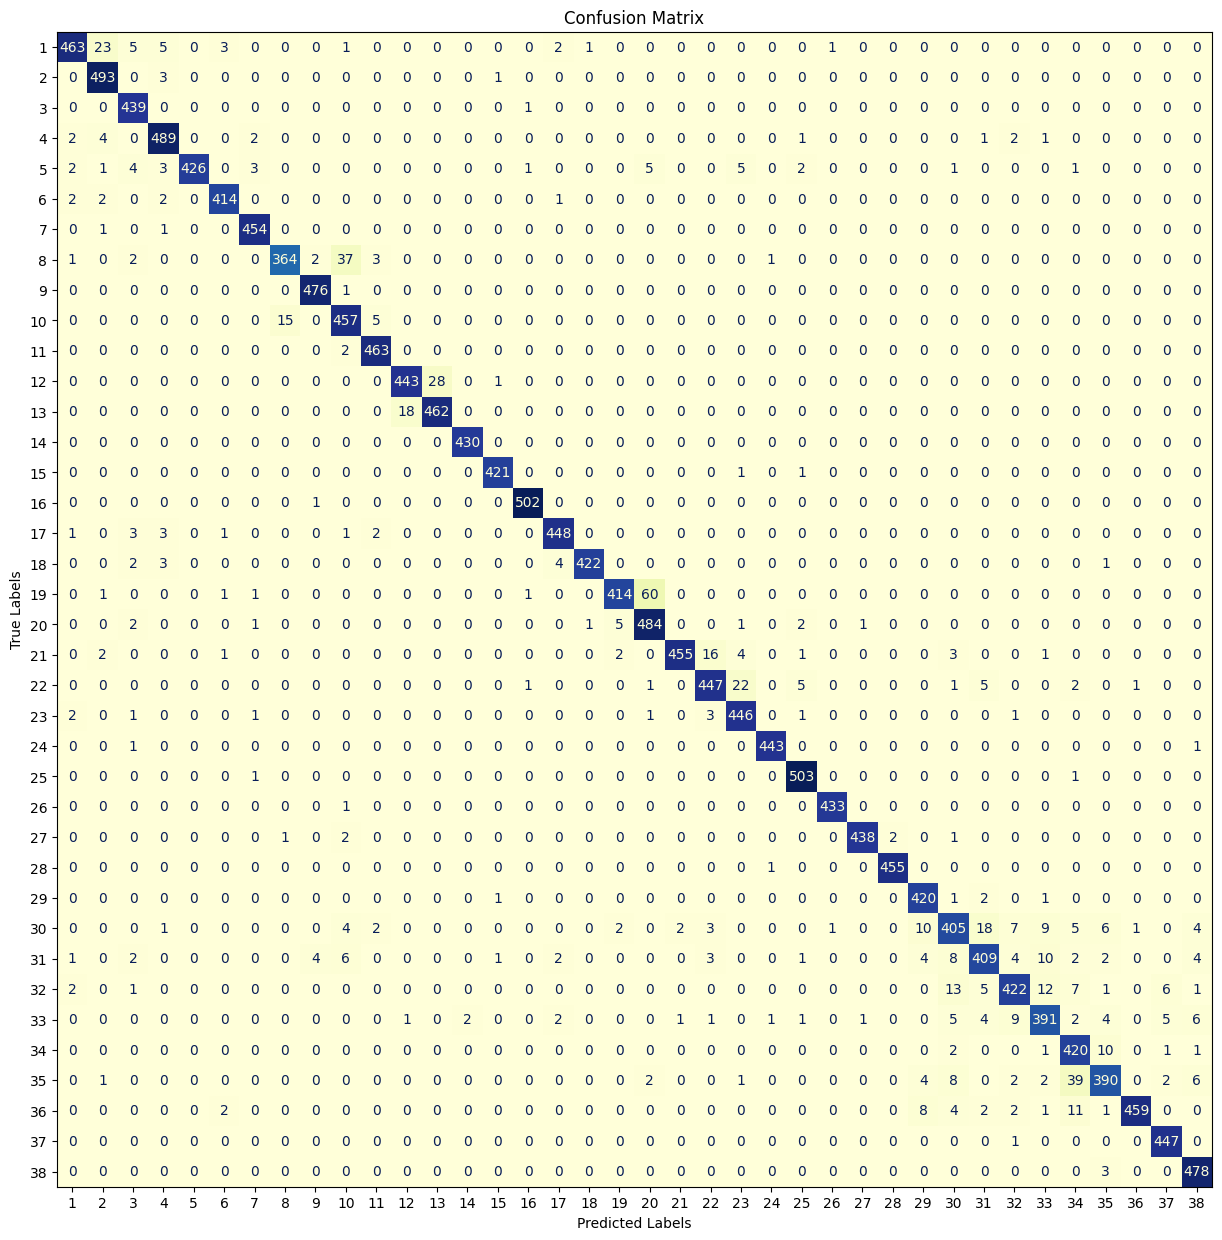

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Your code to generate the confusion matrix plot
plt.figure(figsize=(20, 5))
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(range(1, 39)))
fig, ax = plt.subplots(figsize=(15, 15))
disp.plot(ax=ax, colorbar=False, cmap='YlGnBu')
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Save the figure
plt.savefig('confusion_matrix.png')

# Display the plot
plt.show()
